In [28]:
# install kaggle package
!pip install -q kaggle

In [29]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"valeriandwi","key":"c2f0e4fe46204e73ddda533de75d0adf"}'}

In [30]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [31]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.23G/3.24G [00:36<00:00, 158MB/s]
100% 3.24G/3.24G [00:36<00:00, 96.0MB/s]


In [32]:
# unzip
!mkdir fish-dataset
!unzip -qq a-large-scale-fish-dataset.zip -d fish-dataset
!ls fish-dataset

mkdir: cannot create directory ‘fish-dataset’: File exists
Fish_Dataset  license.txt  NA_Fish_Dataset  README.txt	Segmentation_example_script.m


In [33]:
#import libraries
import os
import glob as gb
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [34]:
image_dir = Path('/content/fish-dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

In [35]:
# Concatenate filepaths and labels
images_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
images_df = images_df[images_df['Labels'].apply(lambda x: x[-2:] != 'GT')]

# Shuffle the DataFrame and reset index
images_df = images_df.sample(frac=1).reset_index(drop = True)

# Show the result
images_df.head()

,Filepaths,Labels
0,/content/fish-dataset/Fish_Dataset/Fish_Datase...,Red Mullet
1,/content/fish-dataset/Fish_Dataset/Fish_Datase...,Sea Bass
2,/content/fish-dataset/Fish_Dataset/Fish_Datase...,Gilt-Head Bream
3,/content/fish-dataset/Fish_Dataset/Fish_Datase...,Sea Bass
4,/content/fish-dataset/Fish_Dataset/Fish_Datase...,Shrimp


In [36]:
#Show images count per fish type
images_df.Labels.value_counts()

Red Mullet            1000
Sea Bass              1000
Gilt-Head Bream       1000
Shrimp                1000
Trout                 1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Red Sea Bream         1000
Striped Red Mullet    1000
Name: Labels, dtype: int64

<Axes: xlabel='Labels', ylabel='count'>

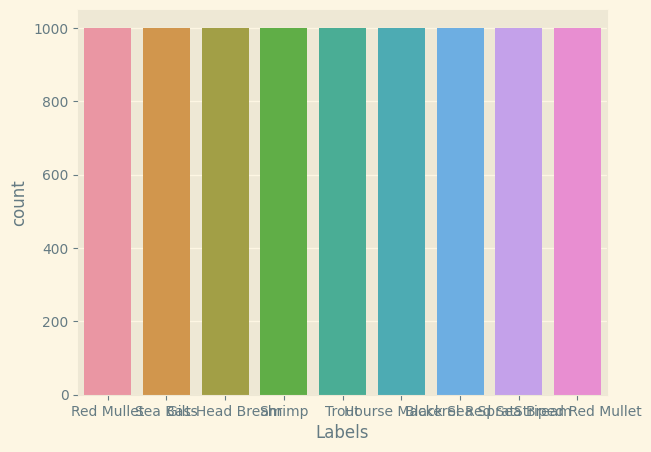

In [37]:
#Show distribute data per class
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=images_df,x='Labels')

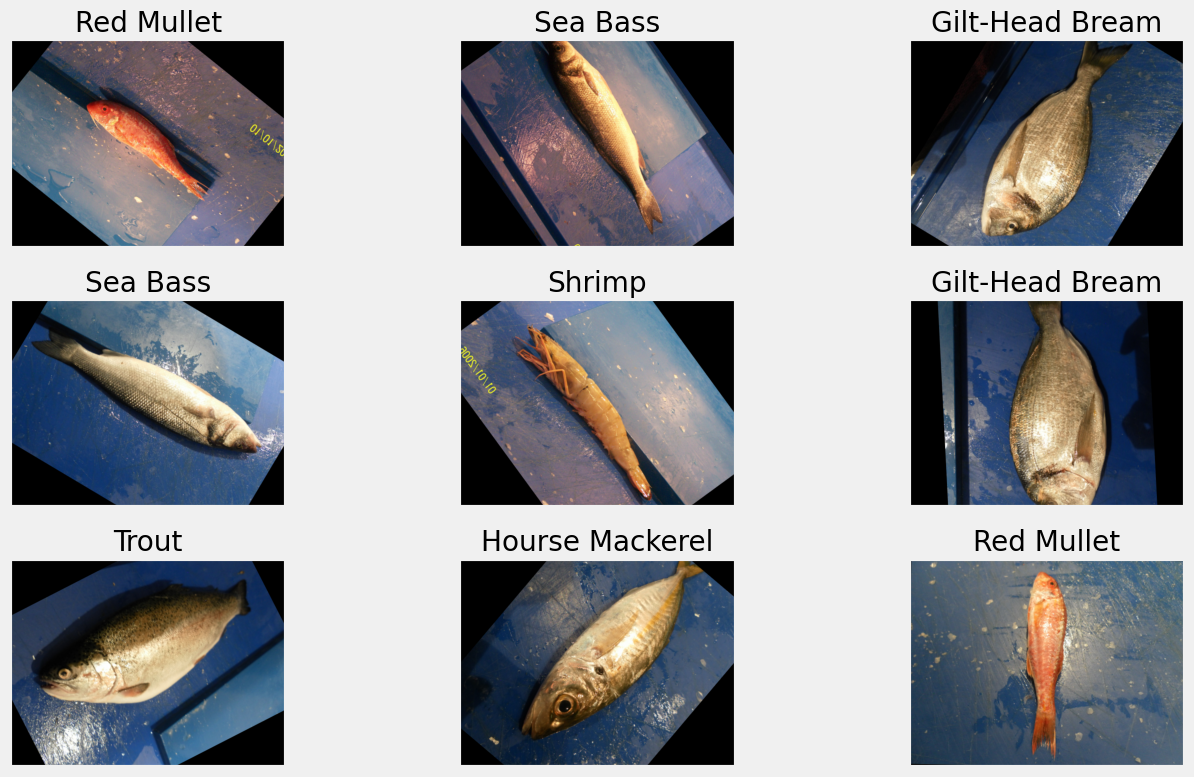

In [38]:
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8),constrained_layout=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_df.Filepaths[i]))
    ax.set_title(images_df.Labels[i])
plt.tight_layout()
plt.show()

Splitting Data

In [39]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

input_shape = (224, 224, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 32)        0

Generate Data

In [40]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [41]:
batch_size = 64

data_train = train_generator.flow_from_directory(
    image_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_generator.flow_from_directory(
    image_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


**Prepocessing**

In [42]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [43]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [44]:
history = model.fit(data_train, validation_data=data_val, epochs=40, callbacks=[callbacks])

Epoch 1/40
225/225 [==============================] - 146s 599ms/step - loss: 1.5147 - accuracy: 0.4131 - val_loss: 1.2988 - val_accuracy: 0.5617
Epoch 2/40
225/225 [==============================] - 131s 582ms/step - loss: 0.9089 - accuracy: 0.6616 - val_loss: 1.0584 - val_accuracy: 0.6714
Epoch 3/40
225/225 [==============================] - 133s 593ms/step - loss: 0.6485 - accuracy: 0.7619 - val_loss: 0.8219 - val_accuracy: 0.7594
Epoch 4/40
225/225 [==============================] - 133s 593ms/step - loss: 0.4630 - accuracy: 0.8315 - val_loss: 0.8005 - val_accuracy: 0.7931
Epoch 5/40
225/225 [==============================] - 131s 583ms/step - loss: 0.3737 - accuracy: 0.8674 - val_loss: 0.6574 - val_accuracy: 0.8183
Epoch 6/40
225/225 [==============================] - 134s 596ms/step - loss: 0.2903 - accuracy: 0.8960 - val_loss: 0.7552 - val_accuracy: 0.8042
Epoch 7/40
225/225 [==============================] - 132s 587ms/step - loss: 0.2226 - accuracy: 0.9199 - val_loss: 1.7321 -

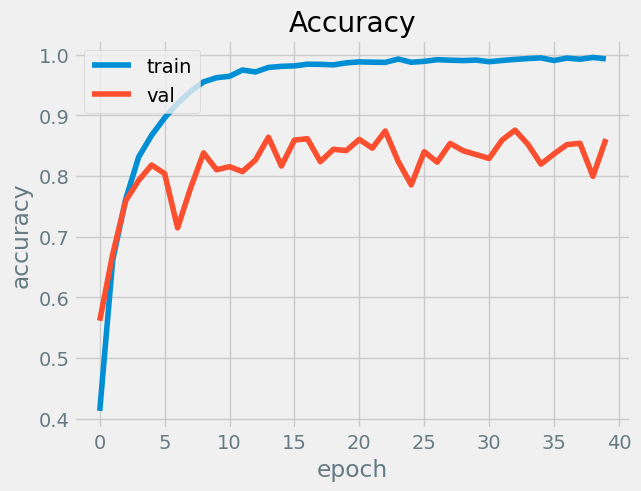

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


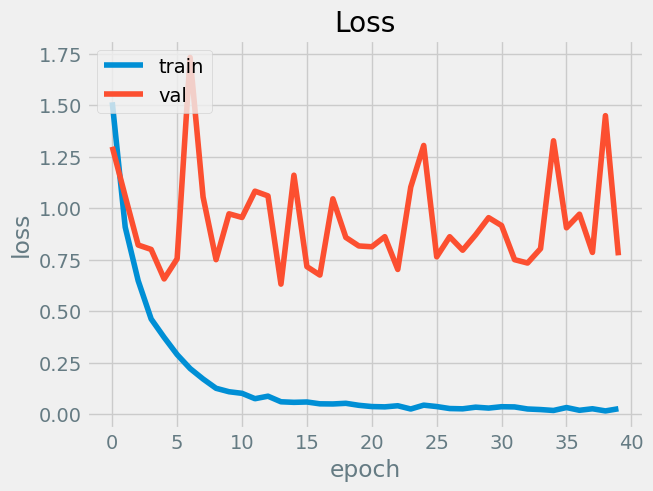

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)


In [52]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root   10043932 Jan 11 04:39 model.tflite
